# PA9 HITS

## Hyperlink-induced topic search (HITS) Algorithm

We will briefly discuss HITS algorithm, an alternative algorithm to PageRank, that is another popular node ranking algorithm in graphs. For an in-depth description of the algorithm, please refer to <a href="http://pi.math.cornell.edu/~mec/Winter2009/RalucaRemus/Lecture4/lecture4.html"> this link </a>

This algorithm was developed by Jon M. Kleinberg, and the original paper can be found <a href="https://www.cs.cornell.edu/home/kleinber/auth.pdf"> here </a>

#### Authorities and Hubs
When searching for information online, there are two main categories of webpages you will tend to run accross. **Authority** refers to a webpage that contains valuable information on a subject, and **hubs** are webpages that advertise the aurhoritative pages. 

For instance, let us say you look up a good laptop to purchase for work or personal use. An **authority** web page you find during such a search might be the home page of microsoft, apple, lenovo, or other companies that sell laptops. A **hub** page may be a laptop review site, such as pcmag. (Note: We are not vouching that pcmag is a trusted review site, please conduct your own research before making any purchase). 

#### Authority and Hub Score
Now that we have defined what it means for a page to be an authority or hub, we can assign an **authority score** and **hub score** to each webpage. A higher **authority score** occurs if the page is pointed to by pages with high **hub scores**. A higher **hub score** occurs if the page points to many pages with high **authority scores**. As you can see, the scores are highly recursive. 

We can keep track of the scores of all webpages in two separate vectors:
1. **Authority vector**, in which each element, $a_i$, will contain the authority score of page i
2. **Hub vector**, in which each element, $h_i$, will contain the hub score of page i.

Notice that each page has both an authority score and hub score.

### Mathematical definition of HITS
Given an adjacency matrix of a directed graph, HITS computes the hub and authority score vectors which can be used for ranking nodes in the graph. 

* **Input**: adjacency matrix $\mathbf{A}\in \mathbb{R}^{n \times n}$ of a graph $G=(V, E)$
* **Output**: hub score vector $\mathbf{h} \in \mathbb{R}^{n}$, and authority score vector $\mathbf{a} \in \mathbb{R}^{n}$ such that

    - $\mathbf{h} = \mathbf{A}\mathbf{a}$
    - $\mathbf{a} = \mathbf{A}^{\top}\mathbf{h}$

* The above equations are called the equations for HITS.

Note that HITS does not require the row-normalized adjacency matrix.

### Iterative Algorithm for HITS
The hub and authority score vectors, $\mathbf{h}$ and $\mathbf{a}$, are obtained by iteratively computing the equations for HITS.   
Note that for each iteration, we need to L2-normalize the vectors $\mathbf{h}$ and $\mathbf{a}$.
The following pseudo-code represents the iterative algorithm for HITS. 

<img src="./iterative-algorithm-hits_pic.png" width="400">

### Exact solution of HITS

We can directly compute the hub and authority score vectors of HITS as follows:
* The hub score vector $\mathbf{h}$ is the principle eigenvector of $\mathbf{A}\mathbf{A}^{\top}$.
* The authority score vector $\mathbf{a}$ is the principle eigenvector of $\mathbf{A}^{\top}\mathbf{A}$.

The principle eigenvector of a matrix is an eigenvector of the largest eigenvalue. 
Suppose the Singular Value Decomposition (SVD) of the adjacency matrix is $\mathbf{A}=\mathbf{U}\mathbf{S}\mathbf{V}^{\top}$. Then,
* $\mathbf{h}$ is the first (most left) vector of $\mathbf{U}$. 
* $\mathbf{a}$ is the first (most left) vector of $\mathbf{V}$.

We will not describe the detailed proofs for the above statements, but we can use them as the exact solutions for the hub and authority score vectors. 

We will implement the following function to compute the exact solutions. 
Note that since the adjacency matrix $\mathbf{A}$ is a sparse matrix, we will use `svds` (sparse SVD) in `scipy`.
* `svds`: this performs SVD on a sparse matrix
    - https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.linalg.svds.html

-----

## Sparse Matrices

In this assignment, we introduce a representation of matrices and matrix operations in scipy called "**Compressed Sparse Row matrix (CSR)**", that is very useful for sparse matrices, namely graphs that have relatively few edges. 

All of its documentation can be found at this link <a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html"> at this link </a>

You will notice that the adjacency matrix, "self.A" in the code below is not loaded in as a np array. As such if you wanted to take the matrix multiplication of "self.A" and another matrix, B, you **cannot** call np.matmul(A,B) nor can you call np.dot(A,B). Both of these commands will throw an error.

Please refer to the documentation link above. Under "Methods" you will find a list of functions and their appropriate syntax (including the method call for matrix multiplication). 

---

## List of tasks

This assignment is quite long and the pieces you need to complete are not all in one place.

Within the class SparseHits, you need to complete the following functions:
<ol>
    <li>SparseHits.iterate_HITS()</li>
    <li>SparseHits.compute_exact_HITS()</li>
    <li>SparseHits.rank_nodes()</li>
</ol>

Outside of the class SparseHits, you need to complete any cell that has "TO BE COMPLETED BY STUDENT" in the comments.

Any cell with "GIVEN" in the comments will be given

In [1]:
#import cell

# the below commands restrict the number of computation threads to 1
import os
os.environ["MKL_NUM_THREADS"] = "1" 
os.environ["NUMEXPR_NUM_THREADS"] = "1" 
os.environ["OMP_NUM_THREADS"] = "1" 

import numpy as np
from scipy.sparse import csr_matrix, find
import pandas as pd
import matplotlib as plt
from scipy.sparse.linalg import svds

In [187]:
class SparseHITS:
    def load_graph_dataset(self, data_home, is_undirected=False):
        '''
        GIVEN
        
        Load the graph dataset from the given directory (data_home)

        inputs:
            data_home: string
                directory path conatining a dataset (edges.tsv, node_labels.tsv)
            is_undirected: bool
                if the graph is undirected
                
        An instantiation of this class will have the following 3 attributes:
            self.A = the adjacency matrix in the form of a Compressed Sparse Row Matrix
            self.n = number of nodes in the graph
            self.m = number of edges in the graph
            self.node_labels = labels for a graph (loaded in by load_node_labels)
        '''
        # Step 1. self file paths from data_home
        edge_path = "{}/edges.tsv".format(data_home)
        
        # Step 2. read the list of edges from edge_path
        edges = np.loadtxt(edge_path, dtype=int)
        self.edges = edges
        n = int(np.amax(edges[:, 0:2])) + 1
        
        # Step 3. convert the edge list to the weighted adjacency matrix
        rows = edges[:, 0]
        cols = edges[:, 1]
        weights = edges[:, 2]
        
        self.A = csr_matrix((weights, (rows, cols)), shape=(n, n), dtype=float)
        if is_undirected == True:
            self.A = self.A + self.A.T

        self.AT = self.A.T
                
        # Step 4. set n (# of nodes) and m (# of edges)
        self.n = self.A.shape[0]     # number of nodes
        self.m = self.A.nnz          # number of edges
        
        self.node_labels = None
        
    def load_node_labels(self, data_home):
        '''
        GIVEN 
        
        Load the node labels from the given directory (data_home)

        inputs:
            data_home: string
                directory path conatining a dataset
        '''
        label_path = "{}/node_labels.tsv".format(data_home)
        self.node_labels = pd.read_csv(label_path, sep="\t")        
        
    def iterate_HITS(self, epsilon=1e-9, maxIters=100):
        '''
        
        TO BE COMPLETED BY STUDENT
        
        Iterate the HITS equation to obatin the hub & authority score vectors
        
        inputs:
            epsilon: float
                the error tolerance of the iteration
            maxIters: int
                the maximum number of iterations
                
        outputs:
            h: np.ndarray (n x 1 vector)
                the final hub score vector
            a: np.ndarray (n x 1 vector)
                the final authority score vector
            h_residuals: list
                the list of hub residuals over each iteration
            a_residuals: list
                the list of authority residuals over each iteration

        '''
        n= self.n #just to make it easy 
        h_residuals= []#store hub residuals 
        a_residuals= [] #store auth. residuals 
        h1=[1/n for i in range(n)] #old hub values
        a1=[1/n for i in range(n)] #old authority values
        ematrix= [epsilon*1 for i in range(n)] 
        h=[1 for i in range(n)] #hub vector 
        a=[1 for i in range(n)] #authroity vector 
        A=self.A
        AT=self.A.T
       
        for i in range(maxIters):
           
            
            h= A.dot(a1)
            a= AT.dot(h)
            
            h=h/np.linalg.norm(h,2)
            a=a/np.linalg.norm(a,2)
            
            h_residuals.append((np.linalg.norm(h-h1,1)))
            a_residuals.append((np.linalg.norm(a-a1,1)))

            h1= h
            a1= a
            

           
            if (h_residuals[i] < epsilon and a_residuals[i]<epsilon):
                break
            
            
        return h, a, h_residuals, a_residuals 
            
            
            
            
           
        
    
    
    def compute_exact_HITS(self):
        '''
        TO BE COMPLETED BY STUDENT
        
        Compute the exact hub & authority score vectors from the closed form
        
        Remember to use svds from scipy, rather than np.linalg.svd

        outputs:
            h: np.ndarray (n x 1 vector)
                the final hub score vector
            a: np.ndarray (n x 1 vector)
                the final authority score vector
                
        Important note: 
            since SVD is not unique, h and a could end up containing negative values by random chance.
            This would make the result difficult to interpret as our scores are meant to be strictly positive.
        
            Luckily, there is a very easy 2-step fix we can apply:
                First, make "h" and "a" non-negative. 
                    If h = [-1, -5, -2, 5, 2, 3] then making it non-negative would give = [1, 5, 2, 5, 2, 3]
                Second, divide "h" by its L2_norm(h), and divide "a" by its L2_norm(a)      
        
        
        '''
        h,s,a= svds(self.A,1)
        
        h=np.array(h)
        a=np.array(a)
        
        
        h=h.flatten()
        a=a.flatten()
        
        h= np.absolute(h)
        a= np.absolute(a)
        
        h=h/np.linalg.norm(h,2)
        a=a/np.linalg.norm(a,2)
        
        return h,a 
                    
    
    def rank_nodes(self, ranking_scores, labels = False, topk=-1):
        '''
        TO BE COMPLETED BY STUDENT
        
        Rank nodes in the order of given ranking scores. 
        This function reports top-k rankings. 

        inputs:
            ranking_scores: np.ndarray
                ranking score vector
            topk: int
                top-k ranking parameter, default is -1 indicating report all ranks
                
        Output:
            pandas dataframe object containing the top "topk" scores
        '''
        sortedn = (np.argsort(ranking_scores))
        
        sortedn= sortedn[::-1] 
        
        sorteds = ranking_scores[sortedn]
        
        ranking = pd.DataFrame() 
        ranking["rank"] = sortedn[:topk]
        ranking["score"] = sorteds[:topk]
        
    
        return ranking
        

        
    

In [188]:
'''
GIVEN

Run the following cell to load in the data set, it should print out
nodes: 29
edges: 376

if everything is loaded correctly
'''
hits = SparseHITS()
hits.load_graph_dataset('./data/small', is_undirected=False)
print("The number n of nodes: {}".format(hits.n))
print("The number m of edges: {}".format(hits.m))

The number n of nodes: 29
The number m of edges: 376


In [189]:
'''
TO BE COMPLETED BY STUDENT

Run your iterative HITS algorithm on the data set labled "small" and display the top 5 nodes for hub and authoratative scores

Functions you will need to complete and call:
    SparseHITS.iterate_HITS()
    SparseHITS.rank_nodes()
    
Hint: if you call "display(dataframe)", it will print out a pandas data frame in a very nice format

'''

h,a,hr, ar= hits.iterate_HITS()

print("top k ranking based on hub score vectors")
display(hits.rank_nodes(h,labels=False, topk=5))
print("top k ranking based on auth score vectors")
display(hits.rank_nodes(a,labels=False, topk=5))


top k ranking based on hub score vectors


,rank,score
0,4,0.320863
1,5,0.317454
2,3,0.293383
3,2,0.224871
4,21,0.219779


top k ranking based on auth score vectors


,rank,score
0,7,0.269209
1,8,0.262543
2,10,0.260004
3,13,0.249306
4,11,0.242907


### Validate your HITS implementation

You have computed the hob scores and authority score vectors for the data set. How can we determine if our algorithm is correct or not?

In this next section you will check the correctness of your iterative algorithm through two methods:
1. Plot the residuals as a function of iterations for both hub and authoratative vector
2. Compare your iterative results to the exact results obtained via SVD

For your plots, please use <a href="https://matplotlib.org/3.5.0/api/_as_gen/matplotlib.pyplot.semilogy.html"> plt.semilogy </a>. It is called instead of plt.plot, and changes the y-axis to be log scaling and will make the graph look a lot nicer compared to the standard plt.plot. 

----

### Validation part 1 - plotting residuals

In [190]:
'''
TO BE COMPLETED BY STUDENT
'''
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 13}) # set the font-size in the figure

def plot_residuals(residuals, title):
    '''
    Input:
        residuals - list, output from "iterate_HITS", which represents the residual at each iteration for either authority or hub
        title - str, name of the graph
        
    Output: None
    
    This function should produce a meaningful plot using plt.semilogy for the residuals as a function of iteration
    '''
    plt.title(title)
    plt.ylabel('RESIDUAL')
    plt.xlabel('NUM OF ITERATIONS')
    
    plt.semilogy(residuals,marker='*', markersize=5, color='red')
    
    
   
    
    

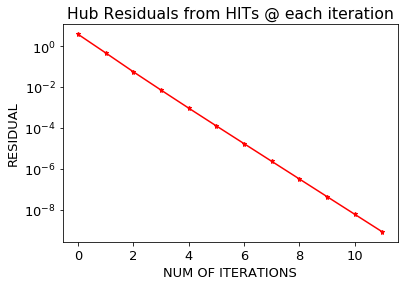

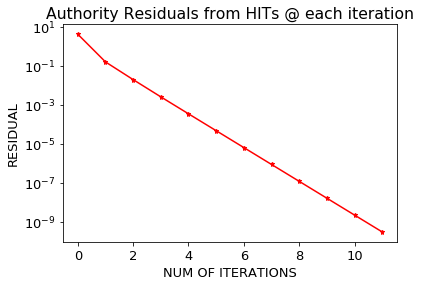

In [191]:
'''
TO BE COMPLETED BY STUDENT

Plot your hub and authoratative residuals below

'''

plot_residuals(hr, 'Hub Residuals from HITs @ each iteration')
plt.show()

plot_residuals(ar, 'Authority Residuals from HITs @ each iteration')
plt.show()

### Validation part 2 - comparing to SVD

In [1]:
'''
TO BE COMPLETED BY STUDENT

Use this cell to compare the difference between the results of the iterative approach
, and the results of the exact solution (SVD)

For full credit please make sure the following is printed:
    1. A well formatted print statement showing the difference between exact and iterative hub scores
    2. a well formatted print statement showing the difference between exact and iterative authority scores. 
'''

he,ae= hits.compute_exact_HITS()


hdiff= np.linalg.norm(he-h,1)
adiff=np.linalg.norm(ae-a,1)

print("Differnce between our exact and iterative hub scores: ", hdiff)
print("Differnce between our exact and iterative authority scores: ", adiff)






NameError: name 'hits' is not defined